In [ ]:
%pip install -U \
  torch==2.0.1 \
  accelerate==0.24.1 \
  transformers==4.33.2 \
  torchvision==0.15.2 \
  diffusers==0.23.1 \
  xformers==0.0.21 \
  bitsandbytes==0.41.1 \
  peft==0.6.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.0/167.0 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849

## 데이터 세트

In [ ]:
local_dir = "./images_molly"

이미지 미리보기

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

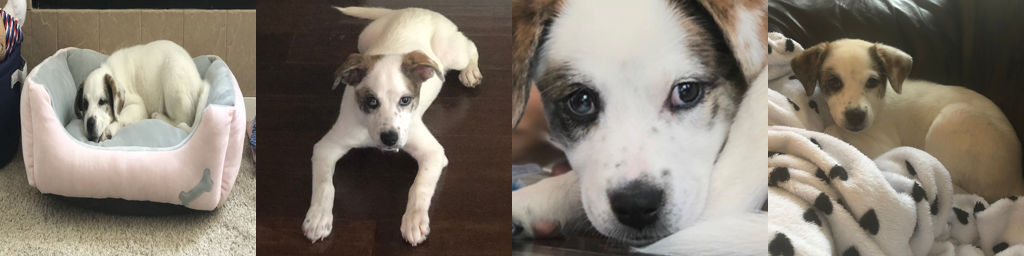

In [ ]:
import glob

imgs = [Image.open(path) for path in glob.glob("./images_molly/*.jpg")]
image_grid(imgs, 1, 4)

# 훈련

In [ ]:
import argparse
import gc
import hashlib
import itertools
import logging
import math
import os
import shutil
import warnings
from pathlib import Path
from typing import Dict

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from huggingface_hub import create_repo, upload_folder
from packaging import version
from PIL import Image
from PIL.ImageOps import exif_transpose
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig

import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DPMSolverMultistepScheduler,
    StableDiffusionXLPipeline,
    UNet2DConditionModel,
)
from diffusers.loaders import LoraLoaderMixin, text_encoder_lora_state_dict
from diffusers.models.attention_processor import LoRAAttnProcessor, LoRAAttnProcessor2_0
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
from diffusers.utils.import_utils import is_xformers_available

logger = get_logger(__name__)

def import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path: str, revision: str, subfolder: str = "text_encoder"
):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path, subfolder=subfolder, revision=revision
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "CLIPTextModelWithProjection":
        from transformers import CLIPTextModelWithProjection

        return CLIPTextModelWithProjection
    else:
        raise ValueError(f"{model_class} is not supported.")


In [ ]:
import argparse
parser = argparse.ArgumentParser()

parser.add_argument(
    "--pretrained_model_name_or_path",
    type=str,
    default="stabilityai/stable-diffusion-xl-base-1.0",
    help="Path to pretrained model or model identifier from huggingface.co/models.",
)
parser.add_argument(
    "--pretrained_vae_model_name_or_path",
    type=str,
    default="madebyollin/sdxl-vae-fp16-fix",
    help="Path to pretrained VAE model with better numerical stability. More details: https://github.com/huggingface/diffusers/pull/4038.",
)
parser.add_argument(
    "--revision",
    type=str,
    default=None,
    required=False,
    help="Revision of pretrained model identifier from huggingface.co/models.",
)
parser.add_argument(
    "--instance_data_dir",
    type=str,
    default="images_molly/",
    help="A folder containing the training data of instance images.",
)
parser.add_argument(
    "--class_data_dir",
    type=str,
    default=None,
    required=False,
    help="A folder containing the training data of class images.",
)
parser.add_argument(
    "--instance_prompt",
    type=str,
    default="a photo of Molly dog",
#    required=True,
    help="The prompt with identifier specifying the instance",
)
parser.add_argument(
    "--class_prompt",
    type=str,
    default=None,
    help="The prompt to specify images in the same class as provided instance images.",
)
parser.add_argument(
    "--validation_prompt",
    type=str,
    default=None,
    help="A prompt that is used during validation to verify that the model is learning.",
)
parser.add_argument(
    "--num_validation_images",
    type=int,
    default=4,
    help="Number of images that should be generated during validation with `validation_prompt`.",
)
parser.add_argument(
    "--validation_epochs",
    type=int,
    default=50,
    help=(
        "Run dreambooth validation every X epochs. Dreambooth validation consists of running the prompt"
        " `args.validation_prompt` multiple times: `args.num_validation_images`."
    ),
)
parser.add_argument(
    "--with_prior_preservation",
    default=False,
    action="store_true",
    help="Flag to add prior preservation loss.",
)
parser.add_argument("--prior_loss_weight", type=float, default=1.0, help="The weight of prior preservation loss.")
parser.add_argument(
    "--num_class_images",
    type=int,
    default=100,
    help=(
        "Minimal class images for prior preservation loss. If there are not enough images already present in"
        " class_data_dir, additional images will be sampled with class_prompt."
    ),
)
parser.add_argument(
    "--output_dir",
    type=str,
    default="dreambooth_lora_model",
    help="The output directory where the model predictions and checkpoints will be written.",
)
parser.add_argument("--seed", type=int, default=None, help="A seed for reproducible training.")
parser.add_argument(
    "--resolution",
    type=int,
    default=1024,
    help=(
        "The resolution for input images, all the images in the train/validation dataset will be resized to this"
        " resolution"
    ),
)
parser.add_argument(
    "--crops_coords_top_left_h",
    type=int,
    default=0,
    help=("Coordinate for (the height) to be included in the crop coordinate embeddings needed by SDXL UNet."),
)
parser.add_argument(
    "--crops_coords_top_left_w",
    type=int,
    default=0,
    help=("Coordinate for (the height) to be included in the crop coordinate embeddings needed by SDXL UNet."),
)
parser.add_argument(
    "--center_crop",
    default=False,
    action="store_true",
    help=(
        "Whether to center crop the input images to the resolution. If not set, the images will be randomly"
        " cropped. The images will be resized to the resolution first before cropping."
    ),
)
parser.add_argument(
    "--train_text_encoder",
    action="store_true",
    help="Whether to train the text encoder. If set, the text encoder should be float32 precision.",
)
parser.add_argument(
    "--train_batch_size", type=int, default=2, help="Batch size (per device) for the training dataloader."
)
parser.add_argument(
    "--sample_batch_size", type=int, default=4, help="Batch size (per device) for sampling images."
)
parser.add_argument("--num_train_epochs", type=int, default=1)
parser.add_argument(
    "--max_train_steps",
    type=int,
    default=200,
    help="Total number of training steps to perform.  If provided, overrides num_train_epochs.",
)
parser.add_argument(
    "--checkpointing_steps",
    type=int,
    default=717,
    help=(
        "Save a checkpoint of the training state every X updates. These checkpoints can be used both as final"
        " checkpoints in case they are better than the last checkpoint, and are also suitable for resuming"
        " training using `--resume_from_checkpoint`."
    ),
)
parser.add_argument(
    "--checkpoints_total_limit",
    type=int,
    default=None,
    help=("Max number of checkpoints to store."),
)
parser.add_argument(
    "--resume_from_checkpoint",
    type=str,
    default=None,
    help=(
        "Whether training should be resumed from a previous checkpoint. Use a path saved by"
        ' `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint.'
    ),
)
parser.add_argument(
    "--gradient_accumulation_steps",
    type=int,
    default=2,
    help="Number of updates steps to accumulate before performing a backward/update pass.",
)
parser.add_argument(
    "--gradient_checkpointing",
    action="store_true",
    help="Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.",
)
parser.add_argument(
    "--learning_rate",
    type=float,
    default=1e-4,
    help="Initial learning rate (after the potential warmup period) to use.",
)
parser.add_argument(
    "--scale_lr",
    action="store_true",
    default=False,
    help="Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.",
)
parser.add_argument(
    "--lr_scheduler",
    type=str,
    default="constant",
    help=(
        'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
        ' "constant", "constant_with_warmup"]'
    ),
)
parser.add_argument(
    "--lr_warmup_steps",
    type=int,
    default=0,
    help="Number of steps for the warmup in the lr scheduler."
)
parser.add_argument(
    "--lr_num_cycles",
    type=int,
    default=1,
    help="Number of hard resets of the lr in cosine_with_restarts scheduler.",
)
parser.add_argument("--lr_power", type=float, default=1.0, help="Power factor of the polynomial scheduler.")
parser.add_argument(
    "--dataloader_num_workers",
    type=int,
    default=0,
    help=(
        "Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process."
    ),
)
parser.add_argument(
    "--use_8bit_adam", action="store_true", help="Whether or not to use 8-bit Adam from bitsandbytes."
)
parser.add_argument("--adam_beta1", type=float, default=0.9, help="The beta1 parameter for the Adam optimizer.")
parser.add_argument("--adam_beta2", type=float, default=0.999, help="The beta2 parameter for the Adam optimizer.")
parser.add_argument("--adam_weight_decay", type=float, default=1e-2, help="Weight decay to use.")
parser.add_argument("--adam_epsilon", type=float, default=1e-08, help="Epsilon value for the Adam optimizer")
parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")

parser.add_argument(
    "--logging_dir",
    type=str,
    default="logs",
    help=(
        "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
        " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
    ),
)
parser.add_argument(
    "--allow_tf32",
    action="store_true",
    help=(
        "Whether or not to allow TF32 on Ampere GPUs. Can be used to speed up training. For more information, see"
        " https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices"
    ),
)
parser.add_argument(
    "--report_to",
    type=str,
    default="tensorboard",
    help=(
        'The integration to report the results and logs to. Supported platforms are `"tensorboard"`'
        ' (default), `"wandb"` and `"comet_ml"`. Use `"all"` to report to all integrations.'
    ),
)
parser.add_argument(
    "--mixed_precision",
    type=str,
    default="fp16",
    choices=["no", "fp16", "bf16"],
    help=(
        "Whether to use mixed precision. Choose between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
        " 1.10.and an Nvidia Ampere GPU.  Default to the value of accelerate config of the current system or the"
        " flag passed with the `accelerate.launch` command. Use this argument to override the accelerate config."
    ),
)
parser.add_argument(
    "--prior_generation_precision",
    type=str,
    default=None,
    choices=["no", "fp32", "fp16", "bf16"],
    help=(
        "Choose prior generation precision between fp32, fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
        " 1.10.and an Nvidia Ampere GPU.  Default to  fp16 if a GPU is available else fp32."
    ),
)
parser.add_argument("--local_rank", type=int, default=-1, help="For distributed training: local_rank")
parser.add_argument(
    "--enable_xformers_memory_efficient_attention",
    action="store_true",
    help="Whether or not to use xformers."
)
parser.add_argument(
    "--rank",
    type=int,
    default=4,
    help=("The dimension of the LoRA update matrices."),
)

#args = parser.parse_args(input_args)

#if input_args is not None:
#args = parser.parse_args(input_args)
# else:

args, _ = parser.parse_known_args()

env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
if env_local_rank != -1 and env_local_rank != args.local_rank:
    args.local_rank = env_local_rank

if args.with_prior_preservation:
    if args.class_data_dir is None:
        raise ValueError("You must specify a data directory for class images.")
    if args.class_prompt is None:
        raise ValueError("You must specify prompt for class images.")
else:
    # 로거가 아직 사용 가능하지 않습니다.
    if args.class_data_dir is not None:
        warnings.warn("You need not use --class_data_dir without --with_prior_preservation.")
    if args.class_prompt is not None:
        warnings.warn("You need not use --class_prompt without --with_prior_preservation.")

#return args

print(args)

Namespace(pretrained_model_name_or_path='stabilityai/stable-diffusion-xl-base-1.0', pretrained_vae_model_name_or_path='madebyollin/sdxl-vae-fp16-fix', revision=None, instance_data_dir='images_molly/', class_data_dir=None, instance_prompt='a photo of Molly dog', class_prompt=None, validation_prompt=None, num_validation_images=4, validation_epochs=50, with_prior_preservation=False, prior_loss_weight=1.0, num_class_images=100, output_dir='dreambooth_lora_model', seed=None, resolution=1024, crops_coords_top_left_h=0, crops_coords_top_left_w=0, center_crop=False, train_text_encoder=False, train_batch_size=2, sample_batch_size=4, num_train_epochs=1, max_train_steps=200, checkpointing_steps=717, checkpoints_total_limit=None, resume_from_checkpoint=None, gradient_accumulation_steps=2, gradient_checkpointing=False, learning_rate=0.0001, scale_lr=False, lr_scheduler='constant', lr_warmup_steps=0, lr_num_cycles=1, lr_power=1.0, dataloader_num_workers=0, use_8bit_adam=False, adam_beta1=0.9, adam_b

In [ ]:
class DreamBoothDataset(Dataset):
    """
    모델을 미세 조정하기 위해 프롬프트와 함께 인스턴스 및 클래스 이미지가 준비된 데이터 세트.
    이 과정에서 이미지를 전처리합니다.
    """

    def __init__(
        self,
        instance_data_root,
        class_data_root=None,
        class_num=None,
        size=args.resolution,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError("Instance images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(self.class_data_root.iterdir())
            if class_num is not None:
                self.num_class_images = min(len(self.class_images_path), class_num)
            else:
                self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        instance_image = exif_transpose(instance_image)

        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            class_image = exif_transpose(class_image)

            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)

        return example


def collate_fn(examples, with_prior_preservation=False):
    pixel_values = [example["instance_images"] for example in examples]

    # 사전 보존을 위해 클래스와 인스턴스 예제를 연결
    # 이렇게 하면 두 번의 순전파 전달을 피할 수 있습니다.
    if with_prior_preservation:
        pixel_values += [example["class_images"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    batch = {"pixel_values": pixel_values}
    return batch


class PromptDataset(Dataset):
    "여러 GPU에서 클래스 이미지를 생성하기 위해 프롬프트를 포함한 간단한 데이터 세트."

    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example


def tokenize_prompt(tokenizer, prompt):
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids
    return text_input_ids


# pipelines.StableDiffusionXLPipeline.encode_prompt에서 가져온 것입니다.
def encode_prompt(text_encoders, tokenizers, prompt, text_input_ids_list=None):
    prompt_embeds_list = []

    for i, text_encoder in enumerate(text_encoders):
        if tokenizers is not None:
            tokenizer = tokenizers[i]
            text_input_ids = tokenize_prompt(tokenizer, prompt)
        else:
            assert text_input_ids_list is not None
            text_input_ids = text_input_ids_list[i]

        prompt_embeds = text_encoder(
            text_input_ids.to(text_encoder.device),
            output_hidden_states=True,
        )

        # 항상 최종 텍스트 인코더의 풀링된 출력에만 관심이 있습니다.
        pooled_prompt_embeds = prompt_embeds[0]
        prompt_embeds = prompt_embeds.hidden_states[-2]
        bs_embed, seq_len, _ = prompt_embeds.shape
        prompt_embeds = prompt_embeds.view(bs_embed, seq_len, -1)
        prompt_embeds_list.append(prompt_embeds)

    prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)
    pooled_prompt_embeds = pooled_prompt_embeds.view(bs_embed, -1)
    return prompt_embeds, pooled_prompt_embeds


def unet_attn_processors_state_dict(unet) -> Dict[str, torch.tensor]:
    """
    반환값:
        어텐션 프로세서 파라미터만 포함된 상태 딕셔너리
    """
    attn_processors = unet.attn_processors

    attn_processors_state_dict = {}

    for attn_processor_key, attn_processor in attn_processors.items():
        for parameter_key, parameter in attn_processor.state_dict().items():
            attn_processors_state_dict[f"{attn_processor_key}.{parameter_key}"] = parameter

    return attn_processors_state_dict

In [ ]:
logging_dir = Path(args.output_dir, args.logging_dir)

accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)

accelerator = Accelerator(
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision=args.mixed_precision,
    log_with=args.report_to,
    project_config=accelerator_project_config,
)

# 각 과정마다 디버깅을 위한 설정 로그를 남기기
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state, main_process_only=False)
if accelerator.is_local_main_process:
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()

# 전달된 경우, 훈련 시드를 설정
if args.seed is not None:
    set_seed(args.seed)

# 사전 보존이 활성화된 경우, 클래스 이미지를 생성
if args.with_prior_preservation:
    class_images_dir = Path(args.class_data_dir)
    if not class_images_dir.exists():
        class_images_dir.mkdir(parents=True)
    cur_class_images = len(list(class_images_dir.iterdir()))

    if cur_class_images < args.num_class_images:
        torch_dtype = torch.float16 if accelerator.device.type == "cuda" else torch.float32
        if args.prior_generation_precision == "fp32":
            torch_dtype = torch.float32
        elif args.prior_generation_precision == "fp16":
            torch_dtype = torch.float16
        elif args.prior_generation_precision == "bf16":
            torch_dtype = torch.bfloat16
        pipeline = StableDiffusionXLPipeline.from_pretrained(
            args.pretrained_model_name_or_path,
            torch_dtype=torch_dtype,
            revision=args.revision,
        )
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = args.num_class_images - cur_class_images
        logger.info(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(args.class_prompt, num_new_images)
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=args.sample_batch_size)

        sample_dataloader = accelerator.prepare(sample_dataloader)
        pipeline.to(accelerator.device)

        for example in tqdm(
            sample_dataloader, desc="Generating class images", disable=not accelerator.is_local_main_process
        ):
            images = pipeline(example["prompt"]).images

            for i, image in enumerate(images):
                hash_image = hashlib.sha1(image.tobytes()).hexdigest()
                image_filename = class_images_dir / f"{example['index'][i] + cur_class_images}-{hash_image}.jpg"
                image.save(image_filename)

        del pipeline
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# 저장소 생성 처리
if accelerator.is_main_process:
    if args.output_dir is not None:
        os.makedirs(args.output_dir, exist_ok=True)

# 토크나이저 적재
tokenizer_one = AutoTokenizer.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="tokenizer", revision=args.revision, use_fast=False
)
tokenizer_two = AutoTokenizer.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="tokenizer_2", revision=args.revision, use_fast=False
)

# 적절한 텍스트 인코더 클래스 적재
text_encoder_cls_one = import_model_class_from_model_name_or_path(
    args.pretrained_model_name_or_path, args.revision
)
text_encoder_cls_two = import_model_class_from_model_name_or_path(
    args.pretrained_model_name_or_path, args.revision, subfolder="text_encoder_2"
)

# 스케줄러와 모델 적재
noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
text_encoder_one = text_encoder_cls_one.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
)
text_encoder_two = text_encoder_cls_two.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder_2", revision=args.revision
)
vae_path = (
    args.pretrained_model_name_or_path
    if args.pretrained_vae_model_name_or_path is None
    else args.pretrained_vae_model_name_or_path
)
vae = AutoencoderKL.from_pretrained(
    vae_path, subfolder="vae" if args.pretrained_vae_model_name_or_path is None else None, revision=args.revision
)
unet = UNet2DConditionModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision
)

# 추가된 어댑터 저순위 적응(Low-Rank Adaptation; LoRA) 레이어만 훈련합니다.
vae.requires_grad_(False)
text_encoder_one.requires_grad_(False)
text_encoder_two.requires_grad_(False)
unet.requires_grad_(False)

# 혼합 정밀도로 훈련하기 위해 모든 고정되는 가중치(변형 자동 인코더(vae), 저순위 적응이 아닌 text_encoder와 저순위 적응(lora)이 아닌 U-Net)를 반 정밀도로 변환.
# 이러한 가중치는 추론에만 사용되므로, 완전 정밀도로 유지할 필요가 없습니다.
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# 변형 자동 인코더와 U-Net을 장치(device)에 불러서 weight_dtype로 변환.
unet.to(accelerator.device, dtype=weight_dtype)

# VAE는 항상 float32로 유지되며 NaN 손실을 피합니다.
vae.to(accelerator.device, dtype=torch.float32)

text_encoder_one.to(accelerator.device, dtype=weight_dtype)
text_encoder_two.to(accelerator.device, dtype=weight_dtype)

if args.enable_xformers_memory_efficient_attention:
    if is_xformers_available():
        import xformers

        xformers_version = version.parse(xformers.__version__)
        if xformers_version == version.parse("0.0.16"):
            logger.warn(
                "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
            )
        unet.enable_xformers_memory_efficient_attention()
    else:
        raise ValueError("xformers is not available. Make sure it is installed correctly")

if args.gradient_checkpointing:
    unet.enable_gradient_checkpointing()
    if args.train_text_encoder:
        text_encoder_one.gradient_checkpointing_enable()
        text_encoder_two.gradient_checkpointing_enable()

# 이제 어텐션 레이어에 새로운 저순위 적응 가중치를 추가
# 올바른 저순위 적응 레이어를 설정
unet_lora_attn_procs = {}
unet_lora_parameters = []
for name, attn_processor in unet.attn_processors.items():
    cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
    if name.startswith("mid_block"):
        hidden_size = unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = unet.config.block_out_channels[block_id]

    lora_attn_processor_class = (
        LoRAAttnProcessor2_0 if hasattr(F, "scaled_dot_product_attention") else LoRAAttnProcessor
    )
    module = lora_attn_processor_class(
        hidden_size=hidden_size, cross_attention_dim=cross_attention_dim, rank=args.rank
    )
    unet_lora_attn_procs[name] = module
    unet_lora_parameters.extend(module.parameters())

unet.set_attn_processor(unet_lora_attn_procs)

# 텍스트 인코더는 🤗 트랜스포머에서 가져온 것이므로 직접 수정할 수 없습니다.
# 대신 어텐션 블록의 순전파 호출을 몽키 패치(monkey-patch)합니다.
if args.train_text_encoder:
    # 학습된지 않는 나머지 모델이 fp16으로 적재되더라도, 데이터 타입은 float32로 유지되도록 합니다.
    text_lora_parameters_one = LoraLoaderMixin._modify_text_encoder(
        text_encoder_one, dtype=torch.float32, rank=args.rank
    )
    text_lora_parameters_two = LoraLoaderMixin._modify_text_encoder(
        text_encoder_two, dtype=torch.float32, rank=args.rank
    )

# `accelerator.save_state(...)`가 적절한 형식으로 직렬화되도록 사용자 지정 저장 및 로딩 훅 생성
def save_model_hook(models, weights, output_dir):
    if accelerator.is_main_process:
        # 선택지는 두 가지입니다. unet의 어텐션 프로세서 레이어만 조정하거나
        # unet과 텍스트 인코더의 어텐션 레이어를 조정하는 것입니다.
        unet_lora_layers_to_save = None
        text_encoder_one_lora_layers_to_save = None
        text_encoder_two_lora_layers_to_save = None

        for model in models:
            if isinstance(model, type(accelerator.unwrap_model(unet))):
                unet_lora_layers_to_save = unet_attn_processors_state_dict(model)
            elif isinstance(model, type(accelerator.unwrap_model(text_encoder_one))):
                text_encoder_one_lora_layers_to_save = text_encoder_lora_state_dict(model)
            elif isinstance(model, type(accelerator.unwrap_model(text_encoder_two))):
                text_encoder_two_lora_layers_to_save = text_encoder_lora_state_dict(model)
            else:
                raise ValueError(f"unexpected save model: {model.__class__}")

            # 해당 모델이 다시 저장되지 않도록 가중치를 제거합니다.
            weights.pop()

        StableDiffusionXLPipeline.save_lora_weights(
            output_dir,
            unet_lora_layers=unet_lora_layers_to_save,
            text_encoder_lora_layers=text_encoder_one_lora_layers_to_save,
            text_encoder_2_lora_layers=text_encoder_two_lora_layers_to_save,
        )

def load_model_hook(models, input_dir):
    unet_ = None
    text_encoder_one_ = None
    text_encoder_two_ = None

    while len(models) > 0:
        model = models.pop()

        if isinstance(model, type(accelerator.unwrap_model(unet))):
            unet_ = model
        elif isinstance(model, type(accelerator.unwrap_model(text_encoder_one))):
            text_encoder_one_ = model
        elif isinstance(model, type(accelerator.unwrap_model(text_encoder_two))):
            text_encoder_two_ = model
        else:
            raise ValueError(f"unexpected save model: {model.__class__}")

    lora_state_dict, network_alphas = LoraLoaderMixin.lora_state_dict(input_dir)
    LoraLoaderMixin.load_lora_into_unet(lora_state_dict, network_alphas=network_alphas, unet=unet_)

    text_encoder_state_dict = {k: v for k, v in lora_state_dict.items() if "text_encoder." in k}
    LoraLoaderMixin.load_lora_into_text_encoder(
        text_encoder_state_dict, network_alphas=network_alphas, text_encoder=text_encoder_one_
    )

    text_encoder_2_state_dict = {k: v for k, v in lora_state_dict.items() if "text_encoder_2." in k}
    LoraLoaderMixin.load_lora_into_text_encoder(
        text_encoder_2_state_dict, network_alphas=network_alphas, text_encoder=text_encoder_two_
    )

accelerator.register_save_state_pre_hook(save_model_hook)
accelerator.register_load_state_pre_hook(load_model_hook)

# Ampere GPU로 더 빠른 훈련을 위해 TF32를 활성화,
# 자세한 내용은 https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices를 참조
if args.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True

if args.scale_lr:
    args.learning_rate = (
        args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
    )

# 16GB GPU에서 메모리 사용량을 줄이거나 모델을 미세 조정하기 위해 8 비트 아담 옵티마이저 활용
if args.use_8bit_adam:
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "To use 8-bit Adam, please install the bitsandbytes library: `pip install bitsandbytes`."
        )

    optimizer_class = bnb.optim.AdamW8bit
else:
    optimizer_class = torch.optim.AdamW

# 옵티마이저 생성
params_to_optimize = (
    itertools.chain(unet_lora_parameters, text_lora_parameters_one, text_lora_parameters_two)
    if args.train_text_encoder
    else unet_lora_parameters
)
optimizer = optimizer_class(
    params_to_optimize,
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

# SDXL UNet에서 필요한 추가 임베딩이나 Ids를 계산합니다.
# 일반 텍스트 임베딩 (`train_text_encoder`가 True가 아닐 때)
# 풀링된 텍스트 임베딩
# 타임 ids

def compute_time_ids():
    # pipeline.StableDiffusionXLPipeline._get_add_time_ids에서 가져온 것입니다.
    original_size = (args.resolution, args.resolution)
    target_size = (args.resolution, args.resolution)
    crops_coords_top_left = (args.crops_coords_top_left_h, args.crops_coords_top_left_w)
    add_time_ids = list(original_size + crops_coords_top_left + target_size)
    add_time_ids = torch.tensor([add_time_ids])
    add_time_ids = add_time_ids.to(accelerator.device, dtype=weight_dtype)
    return add_time_ids


if not args.train_text_encoder:
    tokenizers = [tokenizer_one, tokenizer_two]
    text_encoders = [text_encoder_one, text_encoder_two]

    def compute_text_embeddings(prompt, text_encoders, tokenizers):
        with torch.no_grad():
            prompt_embeds, pooled_prompt_embeds = encode_prompt(text_encoders, tokenizers, prompt)
            prompt_embeds = prompt_embeds.to(accelerator.device)
            pooled_prompt_embeds = pooled_prompt_embeds.to(accelerator.device)
        return prompt_embeds, pooled_prompt_embeds

# 인스턴스 프롬프트를 처리
instance_time_ids = compute_time_ids()
if not args.train_text_encoder:
    instance_prompt_hidden_states, instance_pooled_prompt_embeds = compute_text_embeddings(
        args.instance_prompt, text_encoders, tokenizers
    )

# 사전 보존을 위한 클래스 프롬프트 처리
if args.with_prior_preservation:
    class_time_ids = compute_time_ids()
    if not args.train_text_encoder:
        class_prompt_hidden_states, class_pooled_prompt_embeds = compute_text_embeddings(
            args.class_prompt, text_encoders, tokenizers
        )

# 여기서 메모리를 정리
if not args.train_text_encoder:
    del tokenizers, text_encoders
    gc.collect()
    torch.cuda.empty_cache()

# 정적으로 계산된 변수를 적절히 패킹합니다. 이렇게 하면 데이터 로더에 변수를 전달할 필요가 없습니다.
add_time_ids = instance_time_ids
if args.with_prior_preservation:
    add_time_ids = torch.cat([add_time_ids, class_time_ids], dim=0)

if not args.train_text_encoder:
    prompt_embeds = instance_prompt_hidden_states
    unet_add_text_embeds = instance_pooled_prompt_embeds
    if args.with_prior_preservation:
        prompt_embeds = torch.cat([prompt_embeds, class_prompt_hidden_states], dim=0)
        unet_add_text_embeds = torch.cat([unet_add_text_embeds, class_pooled_prompt_embeds], dim=0)
else:
    tokens_one = tokenize_prompt(tokenizer_one, args.instance_prompt)
    tokens_two = tokenize_prompt(tokenizer_two, args.instance_prompt)
    if args.with_prior_preservation:
        class_tokens_one = tokenize_prompt(tokenizer_one, args.class_prompt)
        class_tokens_two = tokenize_prompt(tokenizer_two, args.class_prompt)
        tokens_one = torch.cat([tokens_one, class_tokens_one], dim=0)
        tokens_two = torch.cat([tokens_two, class_tokens_two], dim=0)

# 데이터 세트 및 데이터 로더 생성
train_dataset = DreamBoothDataset(
    instance_data_root=args.instance_data_dir,
    class_data_root=args.class_data_dir if args.with_prior_preservation else None,
    class_num=args.num_class_images,
    size=args.resolution,
    center_crop=args.center_crop,
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.train_batch_size,
    shuffle=True,
    collate_fn=lambda examples: collate_fn(examples, args.with_prior_preservation),
    num_workers=args.dataloader_num_workers,
)

# 스케줄러와 훈련 단계 수에 대한 수학적 처리.
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if args.max_train_steps is None:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True

lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * accelerator.num_processes,
    num_training_steps=args.max_train_steps * accelerator.num_processes,
    num_cycles=args.lr_num_cycles,
    power=args.lr_power,
)

# `가속기`로 모든 것을 준비합니다.
if args.train_text_encoder:
    unet, text_encoder_one, text_encoder_two, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, text_encoder_one, text_encoder_two, optimizer, train_dataloader, lr_scheduler
    )
else:
    unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, lr_scheduler
    )

# 훈련 데이터 로더 크기가 변경되었을 수 있으므로 총 훈련 단계를 다시 계산합니다.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if overrode_max_train_steps:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
# 훈련 단계 계산 후에 훈련 에포크(epoch) 수 다시 계산합니다.
args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

# 사용하는 트래커를 초기화하고 구성 설정을 저장해야 합니다.
# 트래커는 메인 프로세스에서 자동으로 초기화됩니다.
# accelerator.is_main_process인 경우
accelerator.init_trackers("dreambooth-lora", config=vars(args))

# 훈련 시작!
total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num batches each epoch = {len(train_dataloader)}")
logger.info(f"  Num Epochs = {args.num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {args.max_train_steps}")
global_step = 0
first_epoch = 0

# Potentially load in the weights and states from a previous save
# if args.resume_from_checkpoint:
#     if args.resume_from_checkpoint != "latest":
#         path = os.path.basename(args.resume_from_checkpoint)
#     else:
#         # Get the mos recent checkpoint
#         dirs = os.listdir(args.output_dir)
#         dirs = [d for d in dirs if d.startswith("checkpoint")]
#         dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
#         path = dirs[-1] if len(dirs) > 0 else None
#
#     if path is None:
#         accelerator.print(
#             f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
#         )
#         args.resume_from_checkpoint = None
#     else:
#         accelerator.print(f"Resuming from checkpoint {path}")
#         accelerator.load_state(os.path.join(args.output_dir, path))
#         global_step = int(path.split("-")[1])
#
#         resume_global_step = global_step * args.gradient_accumulation_steps
#         first_epoch = global_step // num_update_steps_per_epoch
#         resume_step = resume_global_step % (num_update_steps_per_epoch * args.gradient_accumulation_steps)

# 각 장치에 진행 표시줄을 한 번만 표시.
progress_bar = tqdm(range(global_step, args.max_train_steps)) #, disable=not accelerator.is_local_main_process)
progress_bar.set_description("Steps")

for epoch in range(first_epoch, args.num_train_epochs):
    unet.train()
    if args.train_text_encoder:
        text_encoder_one.train()
        text_encoder_two.train()
    for step, batch in enumerate(train_dataloader):
        # Skip steps until we reach the resumed step
        if args.resume_from_checkpoint and epoch == first_epoch and step < resume_step:
            if step % args.gradient_accumulation_steps == 0:
                progress_bar.update(1)
            continue

        with accelerator.accumulate(unet):
            pixel_values = batch["pixel_values"].to(dtype=vae.dtype)

            # 이미지를 잠재 공간으로 변환
            model_input = vae.encode(pixel_values).latent_dist.sample()
            model_input = model_input * vae.config.scaling_factor
            if args.pretrained_vae_model_name_or_path is None:
                model_input = model_input.to(weight_dtype)

            # 잠재 공간에 추가될 노이즈를 샘플링
            noise = torch.randn_like(model_input)
            bsz = model_input.shape[0]
            # 각 이미지마다 무작위로 타임스텝을 샘플링
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bsz,), device=model_input.device
            )
            timesteps = timesteps.long()

            # 각 타임스텝의 노이즈 크기에 따라 잠재 공간에 노이즈를 추가
            # (이것이 순방향 확산 과정)
            noisy_model_input = noise_scheduler.add_noise(model_input, noise, timesteps)

            # 사전 보존을 사용함에 따라 반복할 요소를 계산합니다.
            elems_to_repeat = bsz // 2 if args.with_prior_preservation else bsz

            # 노이즈 잔여값을 예측
            if not args.train_text_encoder:
                unet_added_conditions = {
                    "time_ids": add_time_ids.repeat(elems_to_repeat, 1),
                    "text_embeds": unet_add_text_embeds.repeat(elems_to_repeat, 1),
                }
                prompt_embeds_input = prompt_embeds.repeat(elems_to_repeat, 1, 1)
                model_pred = unet(
                    noisy_model_input,
                    timesteps,
                    prompt_embeds_input,
                    added_cond_kwargs=unet_added_conditions,
                ).sample
            else:
                unet_added_conditions = {"time_ids": add_time_ids.repeat(elems_to_repeat, 1)}
                prompt_embeds, pooled_prompt_embeds = encode_prompt(
                    text_encoders=[text_encoder_one, text_encoder_two],
                    tokenizers=None,
                    prompt=None,
                    text_input_ids_list=[tokens_one, tokens_two],
                )
                unet_added_conditions.update({"text_embeds": pooled_prompt_embeds.repeat(elems_to_repeat, 1)})
                prompt_embeds_input = prompt_embeds.repeat(elems_to_repeat, 1, 1)
                model_pred = unet(
                    noisy_model_input, timesteps, prompt_embeds_input, added_cond_kwargs=unet_added_conditions
                ).sample

            # 예측 유형에 따라 손실 목표를 설정
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(model_input, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

            if args.with_prior_preservation:
                # 노이즈와 모델 예측값을 두 부분으로 나누어 각 부분에 대해 손실 계산
                model_pred, model_pred_prior = torch.chunk(model_pred, 2, dim=0)
                target, target_prior = torch.chunk(target, 2, dim=0)

                # 인스턴스 손실을 계산
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

                # 사전 손실 계산
                prior_loss = F.mse_loss(model_pred_prior.float(), target_prior.float(), reduction="mean")

                # 인스턴스 손실에 사전 손실을 합산
                loss = loss + args.prior_loss_weight * prior_loss
            else:
                loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

            accelerator.backward(loss)
            if accelerator.sync_gradients:
                params_to_clip = (
                    itertools.chain(unet_lora_parameters, text_lora_parameters_one, text_lora_parameters_two)
                    if args.train_text_encoder
                    else unet_lora_parameters
                )
                accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # 가속기가 뒤에서 최적화 단계를 수행했는지 확인
        if accelerator.sync_gradients:
            progress_bar.update(1)
            global_step += 1

            if accelerator.is_main_process:
                if global_step % args.checkpointing_steps == 0:
                    # 상태를 저장하기 전에, 해당 저장 단계에서 `checkpoints_total_limit`을 초과하는지 확인
                    if args.checkpoints_total_limit is not None:
                        checkpoints = os.listdir(args.output_dir)
                        checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                        checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                        # 새로운 체크포인트를 저장하기 전에, 체크포인트 수가 `checkpoints_total_limit - 1`개 이하이어야 한다.
                        if len(checkpoints) >= args.checkpoints_total_limit:
                            num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                            removing_checkpoints = checkpoints[0:num_to_remove]

                            logger.info(
                                f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                            )
                            logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                            for removing_checkpoint in removing_checkpoints:
                                removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
                                shutil.rmtree(removing_checkpoint)

                    save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)
                    logger.info(f"Saved state to {save_path}")

        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)

        if global_step >= args.max_train_steps:
            break

    if accelerator.is_main_process:
        if args.validation_prompt is not None and epoch % args.validation_epochs == 0:
            logger.info(
                f"Running validation... \n Generating {args.num_validation_images} images with prompt:"
                f" {args.validation_prompt}."
            )
            # 파이프라인 생성
            if not args.train_text_encoder:
                text_encoder_one = text_encoder_cls_one.from_pretrained(
                    args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
                )
                text_encoder_two = text_encoder_cls_two.from_pretrained(
                    args.pretrained_model_name_or_path, subfolder="text_encoder_2", revision=args.revision
                )
            pipeline = StableDiffusionXLPipeline.from_pretrained(
                args.pretrained_model_name_or_path,
                vae=vae,
                text_encoder=accelerator.unwrap_model(text_encoder_one),
                text_encoder_2=accelerator.unwrap_model(text_encoder_two),
                unet=accelerator.unwrap_model(unet),
                revision=args.revision,
                torch_dtype=weight_dtype,
            )

            # 간소화된 학습 목표를 기준으로 훈련합니다. 이전에 분산을 예측하고 있었다면, 스케줄러가 이를 무시해야 합니다.
            scheduler_args = {}

            if "variance_type" in pipeline.scheduler.config:
                variance_type = pipeline.scheduler.config.variance_type

                if variance_type in ["learned", "learned_range"]:
                    variance_type = "fixed_small"

                scheduler_args["variance_type"] = variance_type

            pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
                pipeline.scheduler.config, **scheduler_args
            )

            pipeline = pipeline.to(accelerator.device)
            pipeline.set_progress_bar_config(disable=True)

            # 추론 실행
            generator = torch.Generator(device=accelerator.device).manual_seed(args.seed) if args.seed else None
            pipeline_args = {"prompt": args.validation_prompt}

            with torch.cuda.amp.autocast():
                images = [
                    pipeline(**pipeline_args, generator=generator).images[0]
                    for _ in range(args.num_validation_images)
                ]

            for tracker in accelerator.trackers:
                if tracker.name == "tensorboard":
                    np_images = np.stack([np.asarray(img) for img in images])
                    tracker.writer.add_images("validation", np_images, epoch, dataformats="NHWC")

            del pipeline
            torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

{'dynamic_thresholding_ratio', 'variance_type', 'clip_sample_range', 'thresholding'} was not found in config. Values will be initialized to default values.


model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

{'attention_type', 'reverse_transformer_layers_per_block', 'dropout'} was not found in config. Values will be initialized to default values.


  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/attention_processor.py:1821: FutureWarning: `LoRAAttnProcessor2_0` is deprecated and will be removed in version 0.26.0. Make sure use AttnProcessor2_0 instead by settingLoRA layers to `self.{to_q,to_k,to_v,to_out[0]}.lora_layer` respectively. This will be done automatically when using `LoraLoaderMixin.load_lora_weights`
  deprecate(


In [ ]:
# 저순위 적응 레이어 저장
accelerator.wait_for_everyone()

# accelerator.is_main_process 라면
unet = accelerator.unwrap_model(unet)
unet = unet.to(torch.float32)
unet_lora_layers = unet_attn_processors_state_dict(unet)

if args.train_text_encoder:
    text_encoder_one = accelerator.unwrap_model(text_encoder_one)
    text_encoder_lora_layers = text_encoder_lora_state_dict(text_encoder_one.to(torch.float32))
    text_encoder_two = accelerator.unwrap_model(text_encoder_two)
    text_encoder_2_lora_layers = text_encoder_lora_state_dict(text_encoder_two.to(torch.float32))
else:
    text_encoder_lora_layers = None
    text_encoder_2_lora_layers = None

StableDiffusionXLPipeline.save_lora_weights(
    save_directory=args.output_dir,
    unet_lora_layers=unet_lora_layers,
    text_encoder_lora_layers=text_encoder_lora_layers,
    text_encoder_2_lora_layers=text_encoder_2_lora_layers,
)

# 최종 추론
# 이전 파이프라인 적재
vae = AutoencoderKL.from_pretrained(
    vae_path,
    subfolder="vae" if args.pretrained_vae_model_name_or_path is None else None,
    revision=args.revision,
    torch_dtype=weight_dtype,
)
pipeline = StableDiffusionXLPipeline.from_pretrained(
    args.pretrained_model_name_or_path, vae=vae, revision=args.revision, torch_dtype=weight_dtype
)

# 간소화된 학습 목표를 기준으로 훈련합니다. 이전에 분산을 예측하고 있었다면, 스케줄러가 이를 무시해야 합니다.
scheduler_args = {}

if "variance_type" in pipeline.scheduler.config:
    variance_type = pipeline.scheduler.config.variance_type

    if variance_type in ["learned", "learned_range"]:
        variance_type = "fixed_small"

    scheduler_args["variance_type"] = variance_type

pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config, **scheduler_args)

# 어텐션 프로세서를 적재
pipeline.load_lora_weights(args.output_dir)

# 추론 실행
images = []
if args.validation_prompt and args.num_validation_images > 0:
    pipeline = pipeline.to(accelerator.device)
    generator = torch.Generator(device=accelerator.device).manual_seed(args.seed) if args.seed else None
    images = [
        pipeline(args.validation_prompt, num_inference_steps=25, generator=generator).images[0]
        for _ in range(args.num_validation_images)
    ]

    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in images])
            tracker.writer.add_images("test", np_images, epoch, dataformats="NHWC")

accelerator.end_training()

Model weights saved in dreambooth_lora_model/pytorch_lora_weights.safetensors


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'attention_type', 'reverse_transformer_layers_per_block', 'dropout'} was not found in config. Values will be initialized to default values.
Loaded unet as UNet2DConditionModel from `unet` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loaded scheduler as EulerDiscreteScheduler from `scheduler` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loaded text_encoder_2 as CLIPTextModelWithProjection from `text_encoder_2` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loaded tokenizer_2 as CLIPTokenizer from `tokenizer_2` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
{'thresholding', 'dynamic_thresholding_ratio', 'algorithm_type', 'variance_type', 'use_lu_lambdas', 'solver_order', 'euler_at_final', 'lower_order_final', 'lambda_min_clipped', 'solve

## 추론

In [ ]:
from diffusers import DiffusionPipeline
import torch

from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix",
                                    torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(args.output_dir)

_ = pipe.to("cuda")

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

{'attention_type', 'reverse_transformer_layers_per_block', 'dropout'} was not found in config. Values will be initialized to default values.
Loaded unet as UNet2DConditionModel from `unet` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loaded scheduler as EulerDiscreteScheduler from `scheduler` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loaded text_encoder as CLIPTextModel from `text_encoder` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loaded tokenizer as CLIPTokenizer from `tokenizer` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loaded text_encoder_2 as CLIPTextModelWithProjection from `text_encoder_2` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loaded tokenizer_2 as CLIPTokenizer from `tokenizer_2` subfolder of stabilityai/stable-diffusion-xl-base-1.0.
Loading unet.


  0%|          | 0/25 [00:00<?, ?it/s]

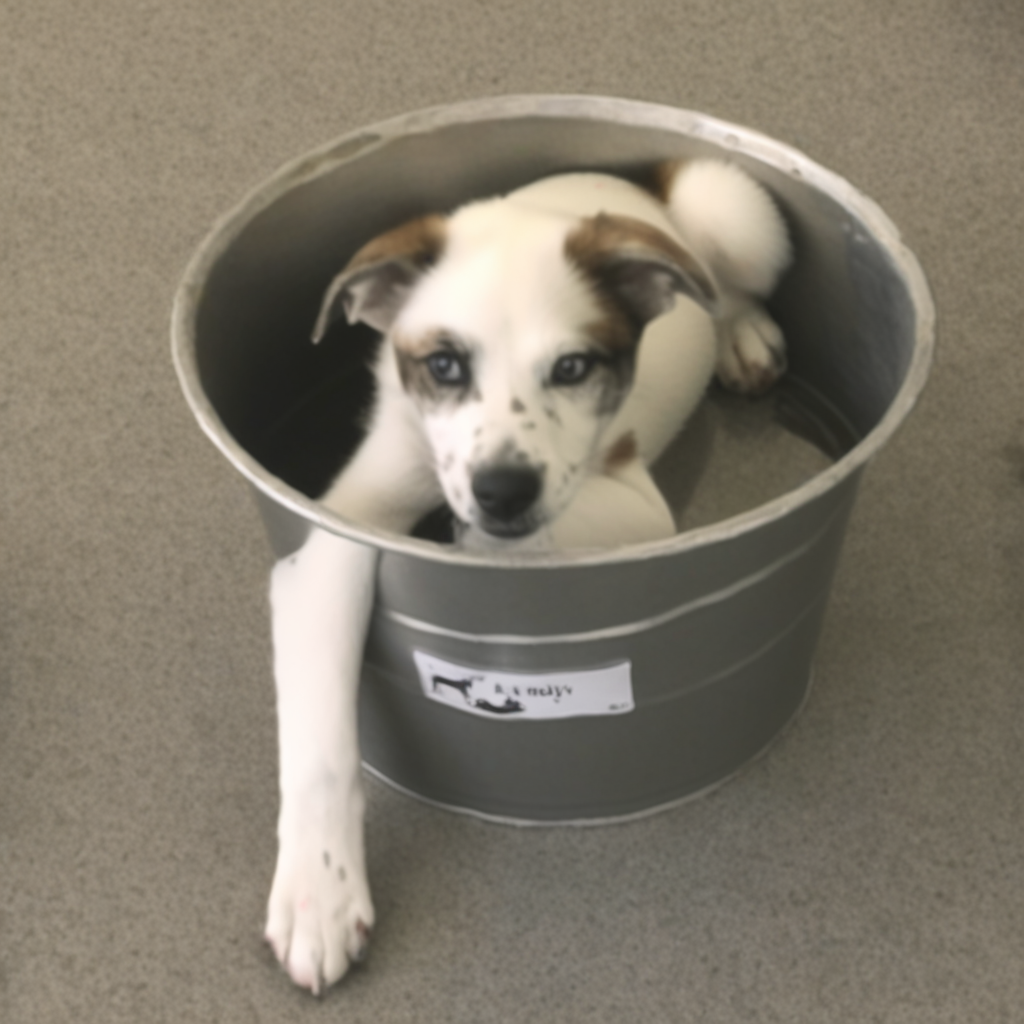

In [ ]:
prompt = "a 5k photo of Molly dog in of a bucket"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image